In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from theano import tensor as T
from scipy import stats
%matplotlib inline

# Chapter 16 - The BART model of risk taking

## 16.1 The BART model
Balloon Analogue Risk Task (BART: Lejuez et al., 2002): Every trial in this task starts by showing a balloon representing a small monetary value. The subject can then either transfer the money to a virtual bank account, or choose to pump, which adds a small amount of air to the balloon, and increases its value. There is some probability, however, that pumping the balloon will cause it to burst, causing all the money to be lost. A trial finishes when either the subject has transferred the money, or the balloon has burst.

$$ \gamma^{+} \sim \text{Uniform}(0,10) $$
$$ \beta \sim \text{Uniform}(0,10) $$
$$ \omega = -\gamma^{+} \,/\,\text{log}(1-p) $$
$$ \theta_{jk} = \frac{1} {1+e^{\beta(k-\omega)}} $$
$$ d_{jk} \sim \text{Bernoulli}(\theta_{jk}) $$

In [2]:
p       = .15  # (Belief of) bursting probability
ntrials = 90   # Number of trials for the BART

Data = pd.read_csv("data/GeorgeSober.txt",sep='\t')
# Data.head()
cash = np.asarray(Data['cash']!=0)
npumps = np.asarray(Data['pumps'])

options = cash + npumps

# response vector
d = []
k = []
for i1, np1 in enumerate(npumps):
    for i in range(np1):
        k.append(i+1)
        d.append(0)
    if cash[i1]:
        k.append(i+2)
        d.append(1)

Applied interval-transform to gammap and added transformed gammap_interval to model.
Applied interval-transform to beta and added transformed beta_interval to model.
Assigned NUTS to gammap_interval
Assigned NUTS to beta_interval
 [-----------------100%-----------------] 5000 of 5000 complete in 3.7 sec

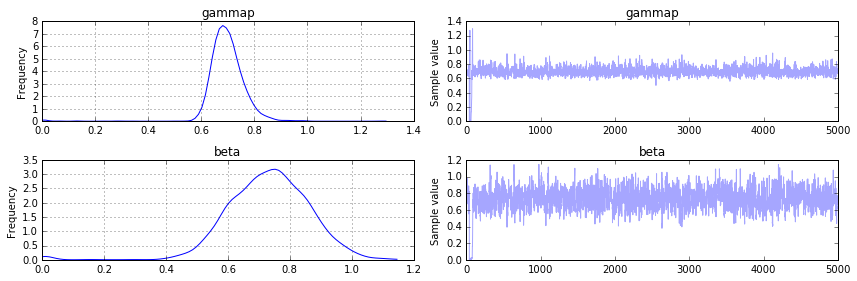

In [12]:
with pm.Model():
    gammap = pm.Uniform("gammap",lower=0,upper=10,testval=1.2)
    beta = pm.Uniform("beta",lower=0,upper=10,testval=.5)
    omega = pm.Deterministic("omega",-gammap/np.log(1-p))
    
    thetajk = pm.Deterministic("thetajk",1 / (1 + T.exp( beta * (k - omega) )))
    
    djk = pm.Bernoulli("djk",p=thetajk, observed=np.equal(d,0))
    # djk = [pm.Bernoulli('djk_%i' % i, p = thetajk[i], observed=d[i]) for i in np.arange(ntrials)]
    
    # start = pm.find_MAP()
    # step = pm.NUTS(scaling=start)
    trace = pm.sample(5e3)
    
pm.traceplot(trace,varnames=['gammap','beta'])
plt.show()

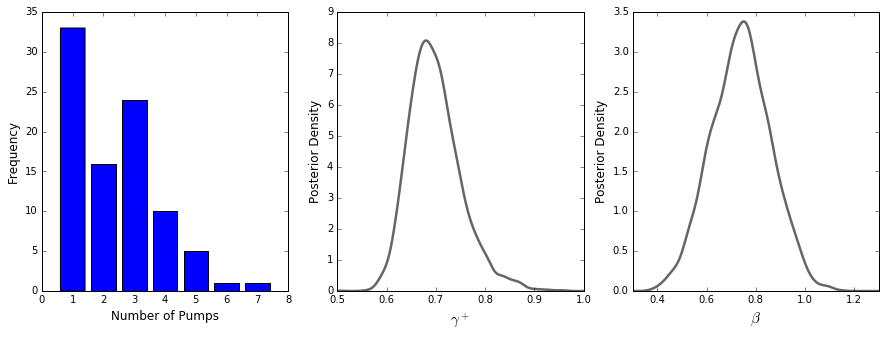

In [13]:
from scipy.stats.kde import gaussian_kde
burnin=2000
gammaplus = trace['gammap'][burnin:]
beta = trace['beta'][burnin:]

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1,3)

ax0 = plt.subplot(gs[0])
ax0.hist(npumps,bins=range(1,9),rwidth=.8,align='left')
plt.xlabel('Number of Pumps',fontsize=12)
plt.ylabel('Frequency',fontsize=12)

ax1 = plt.subplot(gs[1])
my_pdf1 = gaussian_kde(gammaplus)
x1=np.linspace(.5, 1, 200)
ax1.plot(x1, my_pdf1(x1),'k',lw=2.5, alpha=0.6,) # distribution function
plt.xlim((.5,1))
plt.xlabel(r'$\gamma^+$',fontsize=15)
plt.ylabel('Posterior Density',fontsize=12)

ax2 = plt.subplot(gs[2])
my_pdf2 = gaussian_kde(beta)
x2=np.linspace(0.3,1.3, 200)
ax2.plot(x2, my_pdf2(x2),'k',lw=2.5, alpha=0.6,) # distribution function
plt.xlim((0.3,1.3))
plt.xlabel(r'$\beta$',fontsize=15)
plt.ylabel('Posterior Density',fontsize=12)

plt.show()

## 16.2 A hierarchical extension of the BART model
  
  
$$ \mu_{\gamma^{+}} \sim \text{Uniform}(0,10) $$
$$ \sigma_{\gamma^{+}} \sim \text{Uniform}(0,10) $$
$$ \mu_{\beta} \sim \text{Uniform}(0,10) $$
$$ \sigma_{\beta} \sim \text{Uniform}(0,10) $$
$$ \gamma^{+}_i \sim \text{Gaussian}(\mu_{\gamma^{+}}, 1/\sigma_{\gamma^{+}}^2) $$
$$ \beta_i \sim \text{Gaussian}(\mu_{\beta}, 1/\sigma_{\beta}^2) $$
$$ \omega_i = -\gamma^{+}_i \,/\,\text{log}(1-p) $$
$$ \theta_{ijk} = \frac{1} {1+e^{\beta_i(k-\omega_i)}} $$
$$ d_{ijk} \sim \text{Bernoulli}(\theta_{ijk}) $$

In [22]:
p       = .15  # (Belief of) bursting probability
ntrials = 90   # Number of trials for the BART

dall={}
kall={}
npumps={}
Ncond=3
for icondi in range(Ncond):
    if icondi==0:
        Data = pd.read_csv("data/GeorgeSober.txt",sep='\t')
    elif icondi==1:
        Data = pd.read_csv("data/GeorgeTipsy.txt",sep='\t')
    elif icondi==2:
        Data = pd.read_csv("data/GeorgeDrunk.txt",sep='\t')
    # Data.head()
    cash = np.asarray(Data['cash']!=0)
    npumps[icondi] = np.asarray(Data['pumps'])

    # options = cash + npumps

    # response vector
    d = []
    k = []
    for i1, np1 in enumerate(npumps):
        for i in range(np1):
            k.append(i+1)
            d.append(0)
        if cash[i1]:
            k.append(i+2)
            d.append(1)
    
    dall[icondi]=d
    kall[icondi]=k


Applied interval-transform to mu_g and added transformed mu_g_interval to model.
Applied interval-transform to sigma_g and added transformed sigma_g_interval to model.
Applied interval-transform to mu_b and added transformed mu_b_interval to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval to model.
Assigned NUTS to mu_g_interval
Assigned NUTS to sigma_g_interval
Assigned NUTS to mu_b_interval
Assigned NUTS to sigma_b_interval
Assigned NUTS to gammap
Assigned NUTS to beta
 [-----------------100%-----------------] 5000 of 5000 complete in 58.0 sec

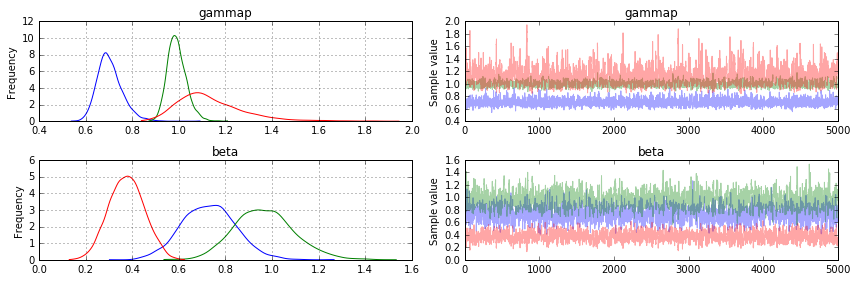

In [21]:
with pm.Model():
    mu_g = pm.Uniform("mu_g",lower=0,upper=10)
    sigma_g = pm.Uniform("sigma_g",lower=0,upper=10)
    mu_b = pm.Uniform("mu_b",lower=0,upper=10)
    sigma_b = pm.Uniform("sigma_b",lower=0,upper=10)
    
    gammap = pm.Normal("gammap",mu=mu_g,sd=sigma_g,shape=Ncond,testval=np.ones(Ncond)*1.2)
    beta = pm.Normal("beta",mu=mu_b,sd=sigma_b,shape=Ncond,testval=np.ones(Ncond)*.5)
    
    djk=[]
    for ic in range(Ncond):
        omega = -gammap[ic]/np.log(1-p)
        thetajk = 1 / (1 + T.exp( beta[ic] * (kall[ic] - omega) ))
    
        djk.append([pm.Bernoulli("djk",p=thetajk, observed=np.equal(dall[ic],0))])
        
    # start = pm.find_MAP()
    # step = pm.NUTS(scaling=start)
    trace2 = pm.sample(5e3)
    
pm.traceplot(trace2,varnames=['gammap','beta'])
plt.show()

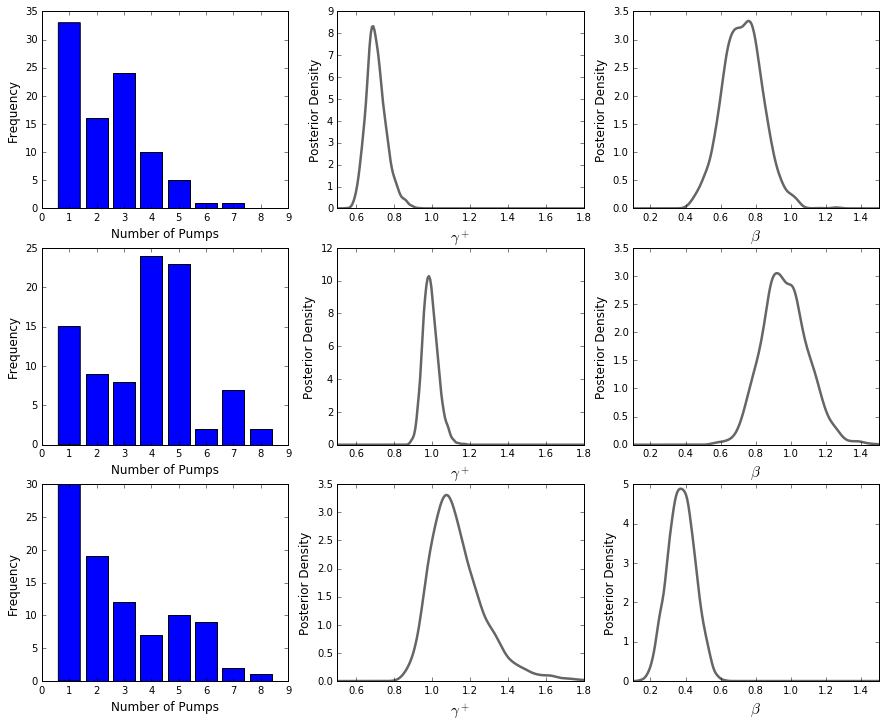

In [25]:
burnin=2000
gammaplus = trace2['gammap'][burnin:]
beta = trace2['beta'][burnin:]

fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(3,3)
for ic in range(Ncond):
    
    ax0 = plt.subplot(gs[0+ic*3])
    ax0.hist(npumps[ic],bins=range(1,10),rwidth=.8,align='left')
    plt.xlabel('Number of Pumps',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)

    ax1 = plt.subplot(gs[1+ic*3])
    my_pdf1 = gaussian_kde(gammaplus[:,ic])
    x1=np.linspace(.5, 1.8, 200)
    ax1.plot(x1, my_pdf1(x1),'k',lw=2.5, alpha=0.6,) # distribution function
    plt.xlim((.5,1.8))
    plt.xlabel(r'$\gamma^+$',fontsize=15)
    plt.ylabel('Posterior Density',fontsize=12)

    ax2 = plt.subplot(gs[2+ic*3])
    my_pdf2 = gaussian_kde(beta[:,ic])
    x2=np.linspace(0.1,1.5, 200)
    ax2.plot(x2, my_pdf2(x2),'k',lw=2.5, alpha=0.6,) # distribution function
    plt.xlim((0.1,1.5))
    plt.xlabel(r'$\beta$',fontsize=15)
    plt.ylabel('Posterior Density',fontsize=12)

plt.show()